In [18]:
# Calling method to clear GPU Memory
# from ClearGPU import gpu_reset
# gpu_reset()

In [19]:
# General Python Libraries
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp

In [20]:
# Loading Data
cifar100 = tf.keras.datasets.cifar100 # Called CIFAR-10 as it has 10 classes

In [21]:
# Creating data splits (training and testing)
(x_train, y_train), (x_test, y_test) = cifar100.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0 # Scaling data to from 0 to 255 to 0 to 1
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape) # Takes the shape of (# Samples, Pixels, Pixels, color space)
print("x_test.shape:", x_test.shape) # Takes the shape of (# Samples, Pixels, Pixels, color space)
print("y_train.shape:", y_train.shape) # Takes the shape of (# Samples)
print("y_test.shape:", y_test.shape) # Takes the shape of (# Samples)

x_train.shape: (50000, 32, 32, 3)
x_test.shape: (10000, 32, 32, 3)
y_train.shape: (50000,)
y_test.shape: (10000,)


In [22]:
# Number of classes
K = len(set(y_train))
print("Number of classes:", K)

Number of classes: 100


In [23]:
# # label mapping
# labels = '''airplane
# automobile
# bird
# cat
# deer
# dog
# frog
# horse
# ship
# truck'''.split()

# Hyperparameters

In [24]:
BATCH_SIZE = 64
EPOCHS = 10

LEARNING_RATE = 0.001
BETA_1 = 0.5

## TensorBoard Hyperparameters

In [25]:
HP_NUM_UNITS_CONV = hp.HParam('num_units_conv', hp.Discrete([32, 64, 128]))
HP_NUM_UNITS_DENSE = hp.HParam('num_units_dense', hp.Discrete([512, 1024, 2048]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.4))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'adamw']))
METRIC_ACCURACY = 'accuracy'

## File Paths

In [26]:
log_folder = "logs/fit/" + datetime.now().strftime("%m%d%Y-%H%M%S")
checkpoint_filepath = './TensorBoard_Checkpoints/checkpoint.model.keras'

# Initializing TensorBoard

In [27]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
# Removing any logs before re-running
!rm -rf logs
!rm -rvf logs

/bin/bash: /home/axian/anaconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/axian/anaconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [29]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS_CONV, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')])

In [30]:
# Data Augmentation
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, BATCH_SIZE)
steps_per_epoch = x_train.shape[0] // BATCH_SIZE # Taking the floor of x_train.shape[0] divided by the batch size

In [31]:
# Building CNN using the functional Keras API
# Model below is based on Modified VGG Model

# Input and Convolutional Components of Neural Network
def build_model(hparams):
    i = Input(shape=x_train[0].shape)
    
    # Layer 1
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Layer 2
    # x = Dropout(hparams[HP_DROPOUT])(x)
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), data_format='channels_first')(x)
    
    #Layer 3
    # x = Dropout(hparams[HP_DROPOUT])(x)
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(hparams[HP_NUM_UNITS_CONV], (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # x = Dropout(hparams[HP_DROPOUT])(x)

    # Traditional Neural Network components
    x = Flatten()(x)
    x = Dropout(hparams[HP_DROPOUT])(x)
    x = Dense(hparams[HP_NUM_UNITS_DENSE], activation='relu')(x)
    x = Dropout(hparams[HP_DROPOUT])(x)
    x = Dense(K, activation='softmax')(x)

    model = Model(i, x) 
    
    return model

In [32]:
def train_test_model(hparams):
    # Compiling model
    model = build_model(hparams)
    
    # Optimizer Selection
    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = 'adam'
    elif optimizer == 'adamw':
        optimizer = AdamW(learning_rate=LEARNING_RATE, beta_1=BETA_1)
    
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=EPOCHS)
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [33]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [34]:
session_num = 0

for num_units_dense in HP_NUM_UNITS_DENSE.domain.values:
  for num_units_conv in HP_NUM_UNITS_CONV.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_NUM_UNITS_CONV: num_units_dense,
            HP_NUM_UNITS_DENSE: num_units_conv,
            HP_DROPOUT: dropout_rate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'num_units_conv': 512, 'num_units_dense': 32, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/10
1563/1563 [==============================] - 43s 26ms/step - loss: 4.6087 - accuracy: 0.0094
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 4.6059 - accuracy: 0.0091
Epoch 3/10
1563/1563 [==============================] - 40s 25ms/step - loss: 4.6059 - accuracy: 0.0086
Epoch 4/10
1563/1563 [==============================] - 40s 25ms/step - loss: 4.6060 - accuracy: 0.0090
Epoch 5/10
1563/1563 [==============================] - 39s 25ms/step - loss: 4.6060 - accuracy: 0.0094
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 4.6059 - accuracy: 0.0085
Epoch 7/10
1563/1563 [==============================] - 39s 25ms/step - loss: 4.6059 - accuracy: 0.0090
Epoch 8/10
1563/1563 [==============================] - 39s 25ms/step - loss: 4.6060 - accuracy: 0.0082
Epoch 9/10
1563/1563 [==============================] - 39

KeyboardInterrupt: 

In [36]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 90605), started 0:00:06 ago. (Use '!kill 90605' to kill it.)

In [ ]:
# Saving Model
# model.save('CIFAR-10_Image_Classifier')

INFO:tensorflow:Assets written to: CIFAR-10_Image_Classifier\assets


INFO:tensorflow:Assets written to: CIFAR-10_Image_Classifier\assets


<bound method Model.summary of <keras.engine.functional.Functional object at 0x00000244D5391AE0>>

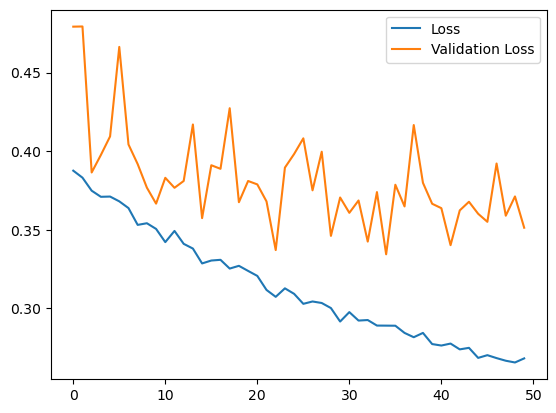

In [ ]:
# Plot loss per iteration
# plt.plot(r.history['loss'], label='Loss')
# plt.plot(r.history['val_loss'], label="Validation Loss")
# plt.legend()